[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/2_nb_descriptive_analytics.ipynb) 

# Chapter 2 - Foundations of descriptive analytics
The second lecture has offered an overview of the field of descriptive analytics. Out of the space of methods for descriptive analytics, the lecture concentrated on cluster analysis. Given this focus in the lecture, the tutorial will revisit the **kMeans** algorithm and deepen our understanding how it segments a given data set. This will also help us to introduce some more Python functionality and further develop our understanding of Python programming and relevant libraries. 

*Need to remember that Notebooks are a blend of text, and code, and results*

Here is the outline of the tutorial:
*   Generating data for cluster analysis 
*   kMeans Algorithm from Scratch
*   kMeans Algorithm using sklearn
*   Finding the optimal "k"

# Cluster Analysis

Cluster analysis is a good example of unsupervised machine learning or machine learning with unlabelled data (no specified target variable). Unsupervised learning algorithms attempt to group observations based on their similarities in features values. In the end, we can try to describe clusters and how they differ from one another. That task, however, is not supported by the algorithm and requires domain expertise. 

An example of this application could be analyzing data from a survey. We may have several distinct groups of potential buyers who reveal distinct preferences through their choices. Cluster analysis can be applied based on their choices to group similar responses and we can then characterize groups to determine marketing efforts.

## Data Generation for cluster analysis

In order to verify that this method of analysis works, we can generate data using sklearn. The function `make_blob()` allows us to create a data for clustering. In a nutshell, we generate data from two Gaussian distribution. The function allows specifying the parameters of these Gaussians. This way, we can decide how similar how dissimilar or dissimilar we want our data to be. Have a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) of appreciate the full functionality of the function. 

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs

np.random.seed(888)

In [76]:
# Generate data in two dimensions using make_blobs:

# Let us first specify some parameters. It is good practice to play with these and verify the effect of such changes
n = 500 # no. samples
centers = [(-2, -2), (2, 2)]  # centers of the two Gaussian
std = 2  # standard deviaton

# Call the function and obtain your data
X, y = make_blobs(n_samples=n, centers=centers, cluster_std=std)

In [77]:
X.shape, y.shape # ensure shape is as expected

((500, 2), (500,))

In [78]:
X[:5] # since X is a NumPy array, use slicing to inspect the data instead of .head() as we would for a pandas DataFrame

array([[-0.26824611, -1.07418431],
       [-4.12196836, -1.73630937],
       [-1.64115373, -4.52581442],
       [ 1.14398146, -0.26504303],
       [ 1.02066215, -1.76253437]])

The function `make_blobs()` also provides a **true cluster assignment** for every data point in the array `y`. By the way we called that function, we have implicitly asked it to create data points for two different clusters. Make sure you understand how that has happened. Which part of the above code would we need to change and how to generate data from, say three different clusters? Check the documentation of `make_blobs()` and/or run a web search to answer this question. As always, it is good practice to play with out demo codes. Try generating and plotting data from three, four, or five different clusters.

In [79]:
y[:5] # true cluster assignment for each data point

array([0, 0, 0, 1, 0])

A picture says more than a thousand words, they say. So let's take a look at our data. Fortunately, we created two-dimensional data so plotting should be easy. We can make use of the variable `y` to color the plot. Recall that the array `y`, which is of the same length as X that specifies, for each data point, to which Gaussian (i.e., cluster) it belongs.

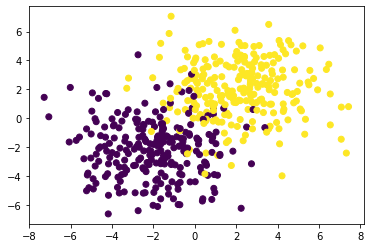

In [80]:
plt.scatter(X[:,0],X[:,1], c=y);  # note the coloring of the data points using the label y

Ok, given the way in which we generated our data, kMeans should have an easy go with it. Play a bit with the parameters that we set above and inspect how the graph (i.e., the data) changes. You can make the clustering task easier or harder. 

Just for fun, we can also verify the (true) mean vectors.

In [81]:
np.mean(X[y == 1], axis=0) # there are two groups based on y values, here are the mean values for each feature for y=1

array([2.17611866, 2.02218582])

In [82]:
np.mean(X[y == 0], axis=0) # here are the mean values for each feature for y=0

array([-1.95229636, -2.16294628])

Well, the data was generated randomly. So some variation is to be expected. If you increase the size of the sample, then the means should approach the values we set above for the parameter `centers`. In case this statement somewhat puzzles you, pause for a while, re-read the previous explanations and codes, and convince yourself that the empirical mean values for the two clusters should approach [-2, -2] and [2, 2], respectively.

# The kMeans algorithm

The kMeans algorithm is an established and widely used method for clustering. Much more sophisticated algorithms exist, many of which are readily available in Python libraries. However, it is good practice to start simple. For the purpose of BADS, knowing kMeans and what clustering in general can do for us is enough. 

kMeans belongs to the family of non-hierarchical cluster analysis methods. K random centroids are created somewhere in the feature space. Then, all data points are assigned to the **nearest centroid** (using some measure of distance). This assignment provides an **initial cluster solution**. Every data point is attached to one cluster. Based on this cluster solution, we **update the centroids**. More specifically, we calculate the updated centroid of each cluster by finding the **empirical mean of the features** across all data points are attachted to that cluster.  After updating the centroids, we repeat the assignment of data points to the nearest (updated) centroid. The **twp-phase process** of updating centroids given a cluster solution, and updating cluster solutions given centroids **repeats** itself until some stopping criterion is met. For example, we can terminate the algorithm once we observe that cluster solutions/centroids stop changing. 

The results of kMeans, that is the cluster solution, may differ based on the initial random selection of centroids. Therefore, it is important to invoke the algorithm multiple times with different random starting points. Then, we can average over all runs in the end or select the *best*, in terms of objective value, cluster solution. Recall that the best solution is the one in which the total sum of the the intra-cluster variances is smallest. 

## kMeans from scratch
We will first implement a couple of function that take care of individual steps in the kMeans algorithm. Afterwards, the function `KMeans_from_scratch()` glues all parts together and represents our customer implementation of the algorithm. Note that in our implementation, we do not start from an artificially created random centroid. Instead, we randomly select one data point per cluster and define this random data point to be the first centroid. Watch out for the call to the function `np.random.choice()` in the below code, which implements this step.

In [83]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2)) # other distance measures also possible

In [84]:
def label_cluster(n_samples, clusters):
    """each sample will get the label of the cluster it was assigned to"""
    labels = np.empty(n_samples) # creates empty array as long as samples for future labels

    for cluster_idx, cluster in enumerate(clusters):
        for sample_index in cluster:
            labels[sample_index] = cluster_idx # assign labels to each sample
    return labels

In [85]:
def create_clusters(K, X, centroids):
    """Assign the samples to the closest centroids to create clusters"""
    clusters = [[] for _ in range(K)] # creates a list of K number of lists
    for idx, sample in enumerate(X):
        centroid_idx = find_closest_centroid(sample, centroids) # find closest centroid for each sample
        clusters[centroid_idx].append(idx) # create index list of closest centroids
    return clusters

In [86]:
def find_closest_centroid(sample, centroids):
    """Distance from each sample to every centroid"""
    distances = [euclidean_distance(sample, point) for point in centroids] # calculate distance from each sample to each centroid
    closest_index = np.argmin(distances) # take closest centroid (one with minimal distance)
    return closest_index

In [87]:
def update_centroids(X, K, n_features, clusters):
    """Assign mean value of cluster features to each centroid"""
    centroids = np.zeros((K, n_features))
    for cluster_idx, cluster in enumerate(clusters):
        cluster_mean = np.mean(X[cluster,:], axis=0) # find new centroid by finding mean of all points assigned to centroid
        centroids[cluster_idx] = cluster_mean # collect all centroids
    return centroids

In [88]:
def is_converged(centroids_old, centroids, K):
    """Check if centroids have changed since last iteration"""
    distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(K)] # check distance between old and new centroids
    return sum(distances) == 0 # return Boolean indicating whether centroids are the same as before or not

In [89]:
def KMeans_from_scratch(X, K=5, max_iters=100):
    """Choose a random set of centroids then optimise using above functions"""
    n_samples, n_features = X.shape
    
    # Initialization 
    random_sample_idx = np.random.choice(n_samples, K, replace=False) # take random sample points to be initial clusters
    centroids = [X[idx] for idx in random_sample_idx] # label these points as centroids

    iteration_num = 0 # initialize iteration tracker

    # Optimization
    for iteration in range(max_iters):
        
        iteration_num += 1 # track iterations required

        clusters = create_clusters(K, X, centroids) # assignment to closest centroids (cluster creation)

        centroids_old = centroids # archive previous centroids
        centroids = update_centroids(X, K, n_features, clusters) # Updating centroids 
        
        # Convergence Confirmation
        if is_converged(centroids_old, centroids, K): # check if last iteration's centroids were the same as current iteration
            labels = label_cluster(n_samples, clusters)
            dist = [euclidean_distance(X[row_num], centroids[int(labels[row_num])]) for row_num in range(X.shape[0])] # get distance from each point to its centroid
            total_dist = np.sum(np.square(dist)) # total distance calculated as sum of squares
            break # exit loop since there was no change since last iteration

    # Classify samples as the index of their clusters
    return labels, iteration_num, K, centroids, total_dist

In [90]:
result = KMeans_from_scratch(X, K=2, max_iters=100)

In [91]:
print("No. Iterations:", result[1], ", No. Centres:", result[2], ", Total Squared Distance {:.4}".format(result[4]))

No. Iterations: 6 , No. Centres: 2 , Total Squared Distance 3.434e+03


In [92]:
print("Centroid Coordinates:", result[3]) # these display average value for each feature of the cluster

Centroid Coordinates: [[-1.96538449 -2.28858345]
 [ 2.23966741  2.20170647]]


## kMeans and "True" Groups

Let's see whether the kMeans function was able to distinguish the groups of y=1 and y=0. Recall that our synthetic data comes with true cluster memberships. However, kMeans does not know about these memberships. In the previous example, we only used our data matrix `X`. We never disclosed the cluster assignment vector `y` to kMeans. kMeans and other cluster methods operated a **unsupervised learners**. Therefore, we can now compare the way in which kMeans have segmented the data to the original true cluster memberships. This comes down to compare the cluster labels per data points, which our customer implementation returns in the array `labels`, the their true counterparts in the array `y`.

Let's see if our results split on the y=1,0 groups or if the algorithm seems to have split the observations in a different way.

In [93]:
result[0][:5] # classifications according to kMeans from scratch for the first five data points

array([0., 0., 0., 1., 0.])

In [94]:
y[:5] # and the corresponding true group membership

array([0, 0, 0, 1, 0])

If you adjust the random seed at the top of this notebook, you may come across a situation where the kMeans function has accurately split the groups BUT flipped the labels. This is because kMeans chooses each group's labels at random.

For example, the true y could be `[1,0,1,1...]` but kMeans will output `[0,1,0,0...]`. 

In order to correct for this, we can use the code below. We first create Boolean index of where `y` is equal to `0`. We then compare this new index to the values in those positions of the result. If we see that the kMeans result actually has a larger quantity of `1` labels in those positions, we can assume that kMeans happened to assign the opposite labels.

In [101]:
from collections import Counter

# Get index values of where y is 0
index_group_0 = y == 0

# Create simpler array of results so we can correct if necessary
result_corrected = result[0]

# Create array of values from our kMeans results ONLY WHERE y is supposed to be 0
label_0 = result_corrected[index_group_0]

# If we see there are more labels of 1, flip the labels. Remember that ~ reverses Boolean values

if Counter(label_0)[1] > Counter(label_0)[0]:
  result_corrected = (~result_corrected.astype(bool)).astype(int)

result_corrected[:5]

array([0., 0., 0., 1., 0.])

We asked you to make changes to the above code. Hence, your solution might be a little different from ours, depending on what and how much you changed. The data generated in the original (unchanged) version of the notebook was pretty simple to cluster. Therefore, you might also obtain a solution where the first five entries of `y` and `result` coincide; or are at least pretty similar. This is to be expected. Let's take a closer look. The following code makes use of the `collections` library and the class `Counter` in particular to count the number of cases in which a data point from cluster 0 ended up in cluster 1 and vice versa. Take a little time for fully understand the code. You will this is approach frequently when it comes to counting list elements.

In [102]:
Counter(result_corrected[y == 1]) # note that there is still a large mix in this group, some features were uninformative, this could be misleading the kMeans function

Counter({1.0: 231, 0.0: 19})

In [103]:
Counter(result_corrected[y == 0])

Counter({0.0: 234, 1.0: 16})

Again, depending upon what kind of changes you made to the code, your results might be anything. For the original notebook version, we would expect to see that most data points were put into their *true cluster* while some errors were also made. This result stems from the fact that the synthetic data was easy to cluster. You can go back, change the code and increase the complexity of the clustering task. Before doing so, run the following code to plot your data one more time while highlighting the data points that have been put into the wrong cluster. I think it's fair to say that kMeans has been a fairly good  job.

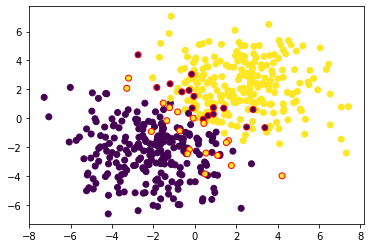

In [104]:
idx = result_corrected==y  # index of the correctly clustered data points
plt.scatter(X[idx,0], X[idx,1], c=y[idx]);  # plot these points
plt.scatter(X[~idx,0], X[~idx,1], c=y[~idx], edgecolor='red', linewidths=1);  # highlight wrongly clustered data points  

## Searching the optimal 'k'
In our case, we can be *pretty sure* (caution: irony in progress) that the optimal value for parameter `k`is 2. Let's pretend we would not know this. We can then use the **elbow method** to determine a suitable setting for `k` by trial and error. To that end, we run the algorithm multiple times with different settings for parameter `k`. We can then plot settings of `k` on the x-axis against the total distance on the y-axis. Wherever we see a bend in the curve (i.e. an elbow), we can consider the corresponding setting of `k` a suitable setting. Anything past the bend of the curve would make the model unnecessarily complex. We would be adding more centroids (i.e., clusters), which we would need to interpret afterwards, without increasing homogeneity in the clusters a lot. 

The following codes illustrate the elbow method for candidate settings of $k=1, ..., 8$. Depending on the size of your data sample, the code might need a little while to run.

In [105]:
# Run kMeans with settings k = 1, 2, ..., 8 and store resulting obejective values (total sum of squares) over clusters
list_total_dist = []

for i in range(1,9):
  results = KMeans_from_scratch(X, K=i, max_iters=100)
  list_total_dist.append(results[4])

list_total_dist

[8163.666584332811,
 3433.7021598689726,
 2801.555768641046,
 2279.2535751930395,
 1784.448831431259,
 1532.9141679280228,
 1304.265831340534,
 1091.0506955475812]

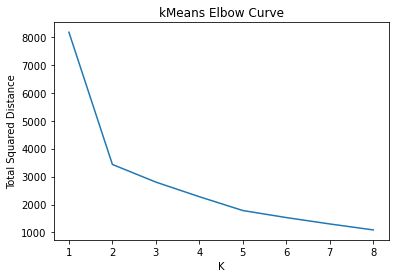

In [106]:
plt.plot(range(1,9), list_total_dist)
plt.title("kMeans Elbow Curve")
plt.ylabel("Total Squared Distance")
plt.xlabel("K")
plt.show()

What a nice and clear elbow. Did we mention that you can change the codes and try them with a more challenging synthetic data set? Hint, hint... 

# kMeans with sklearn

As with the most popular machine learning algorithm, the library sklearn has an easy way to implement the kMeans algorithm. We simply have to import the KMeans function from the sklearn.cluster library.

The documentation for this function can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. Once you create a KMeans object, you can use many methods and attributes to fit, predict and evaluate your model. We illustrate the steps below; essentially re-implementing the above example using only a few lines of code.

In [107]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, init='random', n_init=20, max_iter=100, random_state=888) # create KMeans object with certain settings

res = km.fit_predict(X) # fit to X and also predict labels of X, not using the easier X_simple

In [108]:
km.cluster_centers_ # here are the centroids for kMeans, these display average value for each feature of the cluster

array([[-1.96538449, -2.28858345],
       [ 2.23966741,  2.20170647]])

In [109]:
km.n_iter_ # this is the number of iterations required for stability in this solution

5

In [110]:
km.inertia_ # here is a value similar to total distance for the clusters

3433.702159868974

In [111]:
km.labels_[:10] # here are the labels for each observation from the clustering

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [112]:
y[:10]  # here, the labels done by kMeans are consistent with our y values, they can sometimes be flipped so be careful

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

Again, sklearn may have correctly split groups but chooses labels for them arbitrarily. In case our groups do not correspond with the y labels, we can simply reverse the labels.

In [113]:
results_corrected_sk = km.labels_

if Counter(label_0)[1] > Counter(label_0)[0]:
  results_corrected_sk = (~results_corrected_sk.astype(bool)).astype(int)

results_corrected_sk[:5]

array([0, 0, 0, 1, 0])

In [114]:
Counter(results_corrected_sk[y == 1]) # we have a similar level of purity as we had before with the original dataset

Counter({1: 231, 0: 19})

In [115]:
Counter(results_corrected_sk[y == 0])

Counter({0: 234, 1: 16})

Unsurprisingly, the solutions from the `sklearn` implementation of the kMeans algorithm is not fundamentally different from that of our own implementation. How could it? You may have noted though that the `sklearn` code was a lot faster. Let's finish the demo with re-producing our scatter plot.

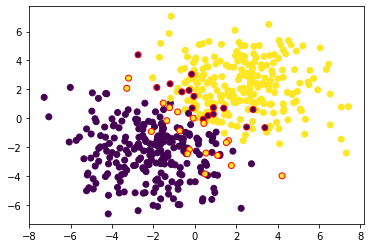

In [116]:
idx = results_corrected_sk == y  # index of the correctly clustered data points
plt.scatter(X[idx, 0], X[idx, 1], c=y[idx]);  # plot these points
plt.scatter(X[~idx, 0], X[~idx, 1], c=y[~idx], edgecolor='red', linewidths=1);  # highlight wrongly clustered data points  

Almost indistinguishable from the above plot. Nice.

### Optimal K in sklearn

We can perform the same elbow curve method on sklearn results. The `.inertia_` attribute on a fit kMeans object allows us to see the sum of squared distance between points and their centroid.

In [117]:
list_total_dist_sklearn = []

for i in range(1,9):
  km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=100, random_state=123) # go from 1 to 8 in the value of centroids
  res = km.fit_predict(X)
  list_total_dist_sklearn.append(km.inertia_) # check how inertia (~total distance) changes as we increase K

list_total_dist_sklearn

[8163.666584332819,
 3433.702159868974,
 2754.2270163009603,
 2143.693630079982,
 1772.1889361680073,
 1468.1531447117534,
 1268.2327468559768,
 1093.4151497922007]

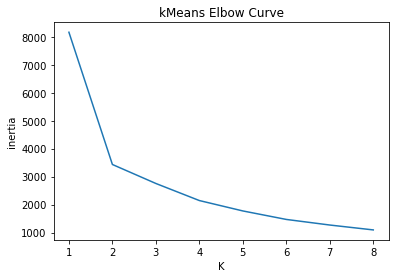

In [118]:
plt.plot(range(1,9), list_total_dist_sklearn) # from this graph, we can see the sharpest bend at 2 again
plt.title("kMeans Elbow Curve")
plt.ylabel("inertia")
plt.xlabel("K")
plt.show()

Here again, we can see the sharpest kink at K=2. 



# Conclusion

kMeans is just one of a few powerful clustering functions whose applications can simplify groups found in data for analysis. While these algorithms can be very powerful, a good understanding of their strengths and weaknesses are critical for an accurate and meaningful analysis of the situation.